In [1]:
!gdown 1I3hAt3wPZ2O7SOcWyvrOH76QCO-RM_70

Downloading...
From: https://drive.google.com/uc?id=1I3hAt3wPZ2O7SOcWyvrOH76QCO-RM_70
To: /kaggle/working/student_depression_dataset.csv
100%|███████████████████████████████████████| 2.90M/2.90M [00:00<00:00, 158MB/s]


> # Step 1: Import Libraries

In [2]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.svm import SVC
from cvxopt import matrix, solvers

import joblib
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import plotly.express as px
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
%matplotlib inline

> # Step 2: Load the Dataset

In [3]:
data = pd.read_csv("/kaggle/working/student_depression_dataset.csv")
data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,'5-6 hours',Unhealthy,'Class 12',Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,'Less than 5 hours',Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,'5-6 hours',Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,'Less than 5 hours',Healthy,'Class 12',Yes,10.0,5.0,No,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

# Step 3: Data Cleaning & Preprocessing

> ## 3.1 Convert and Clean Data Types

In [5]:
# Convert columns that should be categorical
cat_cols = ['Gender', 'City', 'Profession', 'Dietary Habits', 'Degree',
            'Have you ever had suicidal thoughts ?', 'Financial Stress',
            'Family History of Mental Illness']
for col in cat_cols:
    data[col] = data[col].astype('category')

In [6]:
# Create a mapping for Sleep Duration values to numerical categories
sleep_duration_mapping = {
    "'Less than 5 hours'": 1,
    "'5-6 hours'": 2,
    "'7-8 hours'": 3,
    "'More than 8 hours'": 4,
    'Others': 5
}

# Apply the mapping to the 'Sleep Duration' column
data['Sleep Duration'] = data['Sleep Duration'].map(sleep_duration_mapping)

# Display the updated 'Sleep Duration' column
print(data['Sleep Duration'].value_counts())

data['Sleep Duration'] = data['Sleep Duration'].astype('category')

Sleep Duration
1    8310
3    7346
2    6183
4    6044
5      18
Name: count, dtype: int64


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   id                                     27901 non-null  int64   
 1   Gender                                 27901 non-null  category
 2   Age                                    27901 non-null  float64 
 3   City                                   27901 non-null  category
 4   Profession                             27901 non-null  category
 5   Academic Pressure                      27901 non-null  float64 
 6   Work Pressure                          27901 non-null  float64 
 7   CGPA                                   27901 non-null  float64 
 8   Study Satisfaction                     27901 non-null  float64 
 9   Job Satisfaction                       27901 non-null  float64 
 10  Sleep Duration                         27901 non-null  cat

> ## 3.2 Check for Missing Values, Duplicate Row and Outlier

In [8]:
missing_values = data.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64


In [9]:
dup_rows = data[data.drop(columns=['id','Depression']).duplicated(keep=False)]
display(dup_rows)

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression


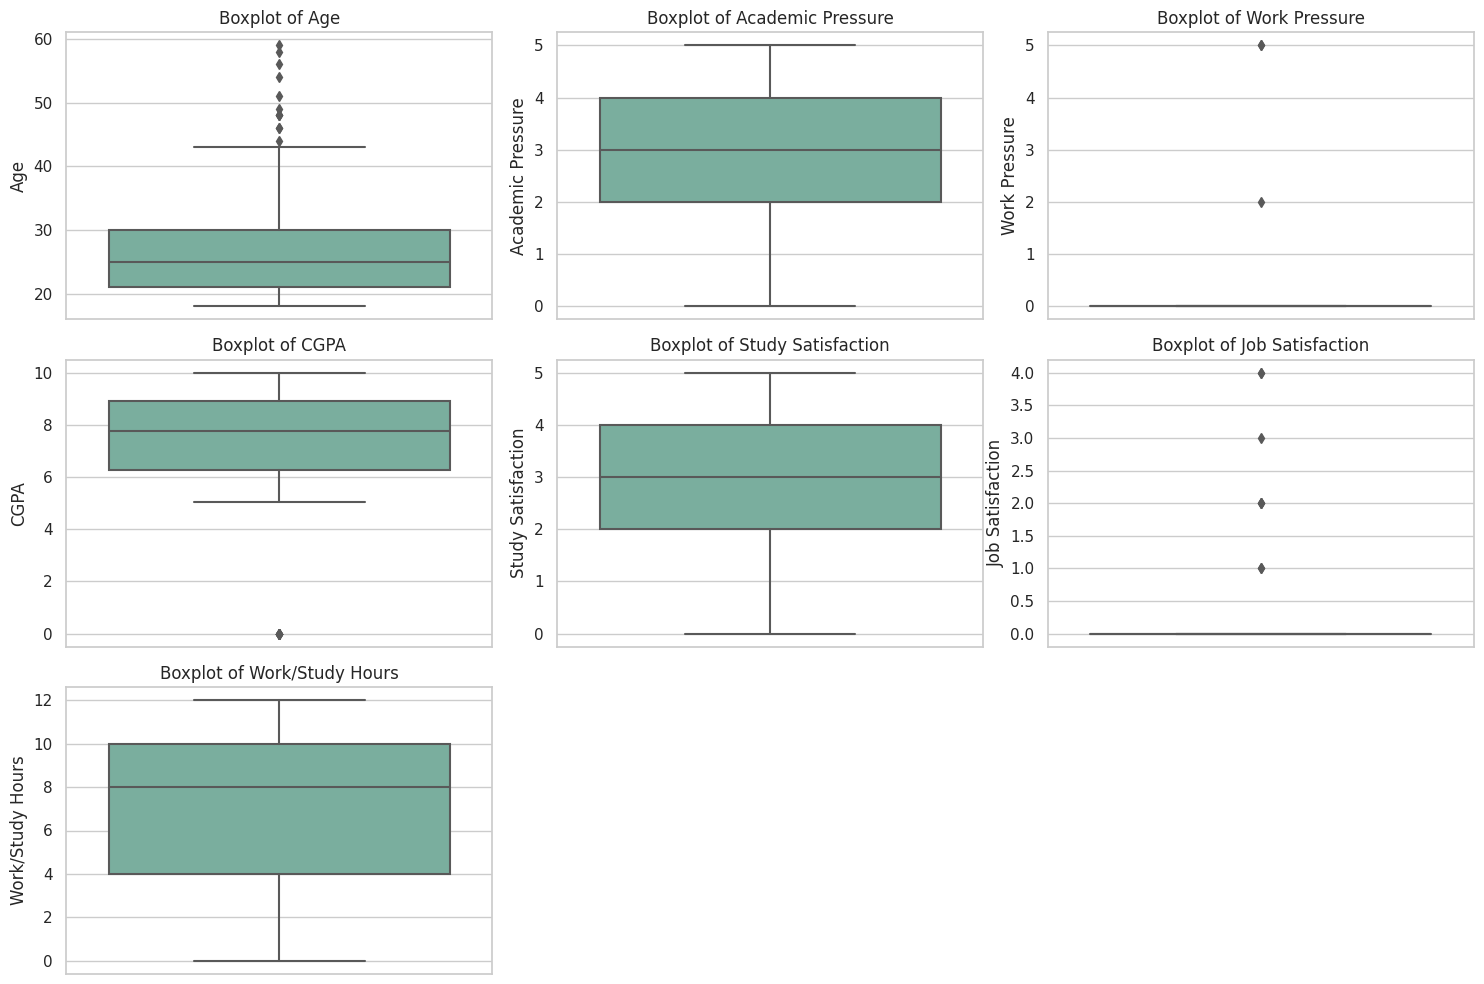

In [10]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[feature], color=(114/255, 182/255, 161/255, 1))
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [11]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist()

outliers_summary = {}
for col in numeric_cols:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    mask_out = (data[col] < lower_bound) | (data[col] > upper_bound)
    outliers_idx = data.index[mask_out].tolist()

    outliers_summary[col] = {
        'count': len(outliers_idx),
        'indices': outliers_idx,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }
    print(f"– {col}: {len(outliers_idx)} outliers (n < {lower_bound:.2f} or n > {upper_bound:.2f})")

total_outliers = sum(v['count'] for v in outliers_summary.values())
print(f"\nTotal of {total_outliers} outliers detected across {len(numeric_cols)} numeric columns.")

all_outlier_idxs = set(idx for info in outliers_summary.values() for idx in info['indices'])
data = data.drop(index=all_outlier_idxs).reset_index(drop=True)
print(f"Dropped {len(all_outlier_idxs)} rows with outliers. New shape: {data.shape}")

– id: 0 outliers (n < -71129.50 or n > 211986.50)
– Age: 12 outliers (n < 7.50 or n > 43.50)
– Academic Pressure: 0 outliers (n < -1.00 or n > 7.00)
– Work Pressure: 3 outliers (n < 0.00 or n > 0.00)
– CGPA: 9 outliers (n < 2.35 or n > 12.87)
– Study Satisfaction: 0 outliers (n < -1.00 or n > 7.00)
– Job Satisfaction: 8 outliers (n < 0.00 or n > 0.00)
– Work/Study Hours: 0 outliers (n < -5.00 or n > 19.00)
– Depression: 0 outliers (n < -1.50 or n > 2.50)

Total of 32 outliers detected across 9 numeric columns.
Dropped 23 rows with outliers. New shape: (27878, 18)


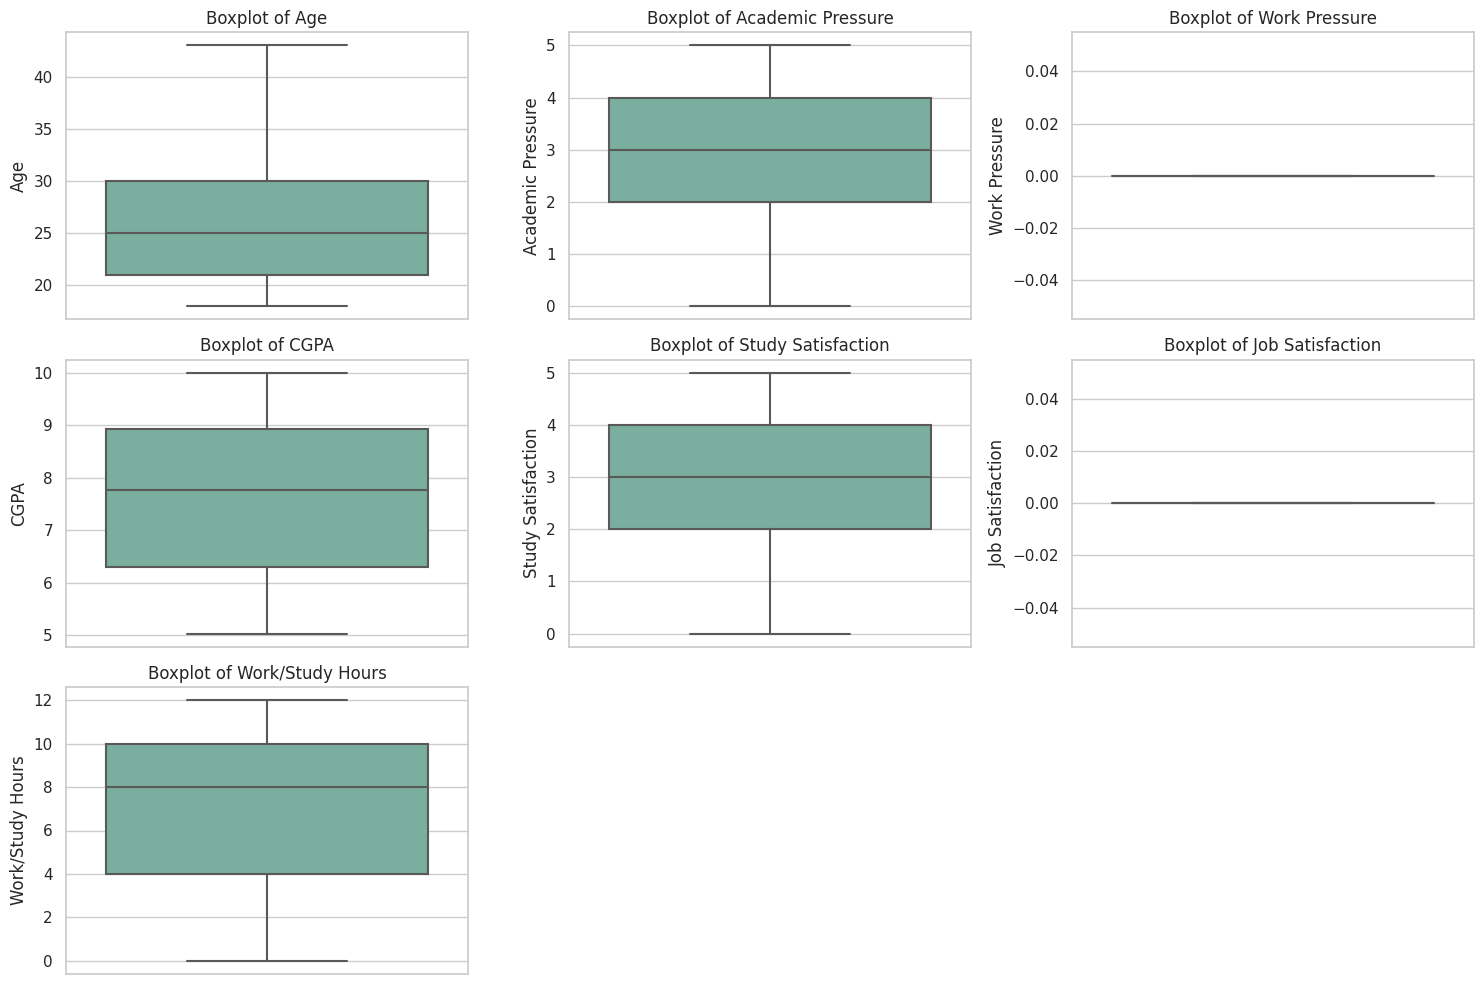

In [12]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA', 
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']

plt.figure(figsize=(15, 10))

for i, feature in enumerate(num_features, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[feature], color=(114/255, 182/255, 161/255, 1))
    plt.title(f'Boxplot of {feature}')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

In [13]:
def v_counts(df):
    for col in df.columns:
        if pd.api.types.is_categorical_dtype(df[col]):
            cnt = df[col].value_counts(dropna=False)
            pct = df[col].value_counts(normalize=True, dropna=False).mul(100).round(3)

            summary = pd.concat([cnt, pct], axis=1)
            summary.columns = ['Count', 'Percent (%)']

            title = f" Column: {col} "
            print(title.center(50, '='))

            display(summary)

v_counts(data)

================= Column: Gender =================


,Count,Percent (%)
Gender,,
Male,15535,55.725
Female,12343,44.275


================== Column: City ==================


,Count,Percent (%)
City,,
Kalyan,1570,5.632
Srinagar,1370,4.914
Hyderabad,1340,4.807
Vasai-Virar,1290,4.627
Lucknow,1153,4.136
Thane,1139,4.086
Ludhiana,1110,3.982
Agra,1093,3.921
Surat,1077,3.863


=============== Column: Profession ===============


,Count,Percent (%)
Profession,,
Student,27847,99.889
Architect,8,0.029
Teacher,6,0.022
'Digital Marketer',3,0.011
'Content Writer',2,0.007
Chef,2,0.007
Doctor,2,0.007
Pharmacist,2,0.007
'Civil Engineer',1,0.004


============= Column: Sleep Duration =============


,Count,Percent (%)
Sleep Duration,,
1,8302,29.780
3,7339,26.325
2,6178,22.161
4,6041,21.669
5,18,0.065


============= Column: Dietary Habits =============


,Count,Percent (%)
Dietary Habits,,
Unhealthy,10307,36.972
Moderate,9913,35.559
Healthy,7646,27.427
Others,12,0.043


================= Column: Degree =================


,Count,Percent (%)
Degree,,
'Class 12',6070,21.773
B.Ed,1866,6.693
B.Com,1506,5.402
B.Arch,1478,5.302
BCA,1433,5.140
MSc,1190,4.269
B.Tech,1152,4.132
MCA,1043,3.741
M.Tech,1022,3.666


= Column: Have you ever had suicidal thoughts ? ==


,Count,Percent (%)
Have you ever had suicidal thoughts ?,,
Yes,17644,63.29
No,10234,36.71


============ Column: Financial Stress ============


,Count,Percent (%)
Financial Stress,,
5.0,6708,24.062
4.0,5769,20.694
3.0,5220,18.724
1.0,5119,18.362
2.0,5059,18.147
?,3,0.011


==== Column: Family History of Mental Illness ====


,Count,Percent (%)
Family History of Mental Illness,,
No,14385,51.6
Yes,13493,48.4


In [14]:
data = data[data['Sleep Duration'] != 5]

data['Sleep Duration'] = data['Sleep Duration'].cat.remove_unused_categories()

print(data['Sleep Duration'].value_counts(dropna=False))

Sleep Duration
1    8302
3    7339
2    6178
4    6041
Name: count, dtype: int64


In [15]:
data = data[data['Financial Stress'] != '?']

data['Financial Stress'] = data['Financial Stress'].cat.remove_unused_categories()

print(data['Financial Stress'].value_counts(dropna=False))

Financial Stress
5.0    6705
4.0    5767
3.0    5216
1.0    5114
2.0    5055
Name: count, dtype: int64


In [16]:
data = data[data['Dietary Habits'] != 'Others']

data['Dietary Habits'] = data['Dietary Habits'].cat.remove_unused_categories()

print(data['Dietary Habits'].value_counts(dropna=False))

Dietary Habits
Unhealthy    10298
Moderate      9906
Healthy       7641
Name: count, dtype: int64


# Step 4: Exploratory Data Analysis (EDA)

> ## 4.1 Overall Distribution of the Target Variable

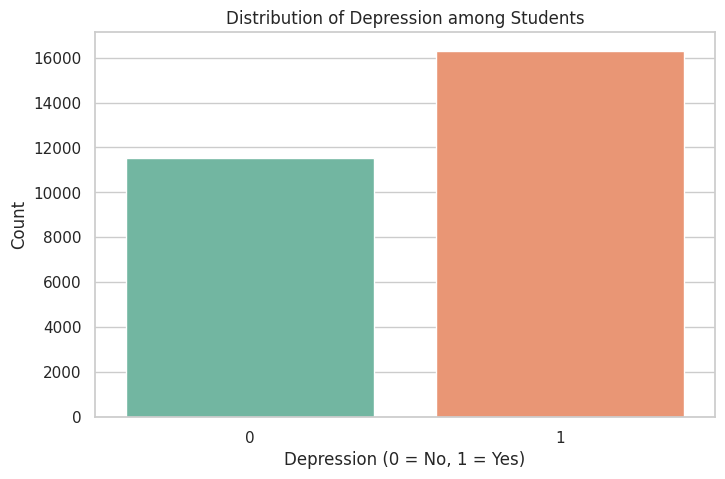

Depression
1    16311
0    11534
Name: count, dtype: int64


In [17]:
plt.figure(figsize=(8,5))
sns.countplot(x='Depression', data=data, palette="Set2")
plt.title("Distribution of Depression among Students")
plt.xlabel("Depression (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

print(data['Depression'].value_counts(dropna=False))

> ## 4.2 Analyzing Categorical Variables

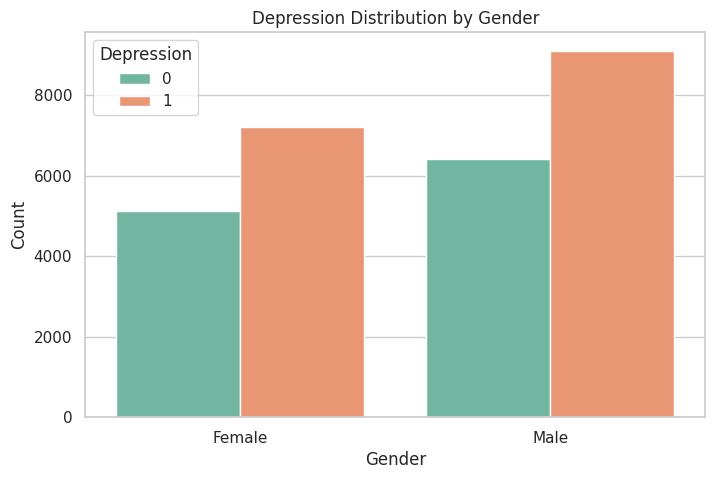

In [18]:
plt.figure(figsize=(8,5))
sns.countplot(x='Gender', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

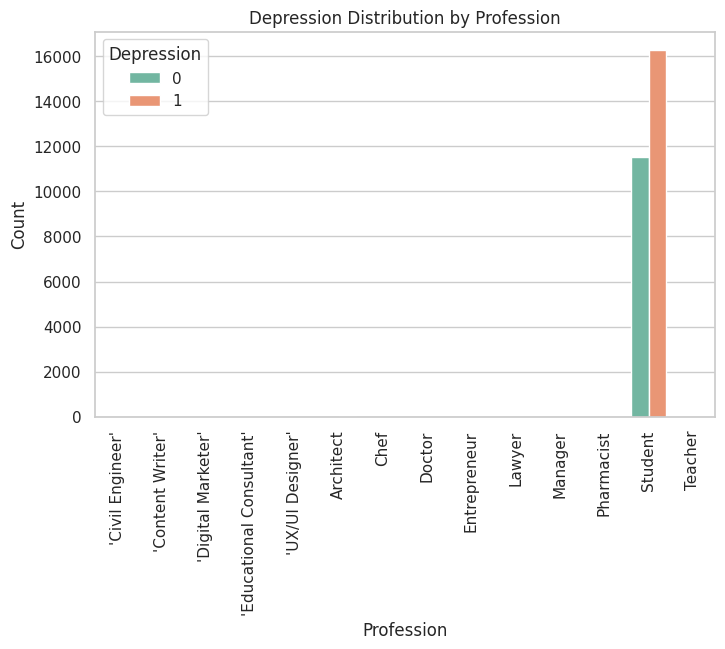

In [19]:
plt.figure(figsize=(8,5))
sns.countplot(x='Profession', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Profession")
plt.xlabel("Profession")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Depression")
plt.show()

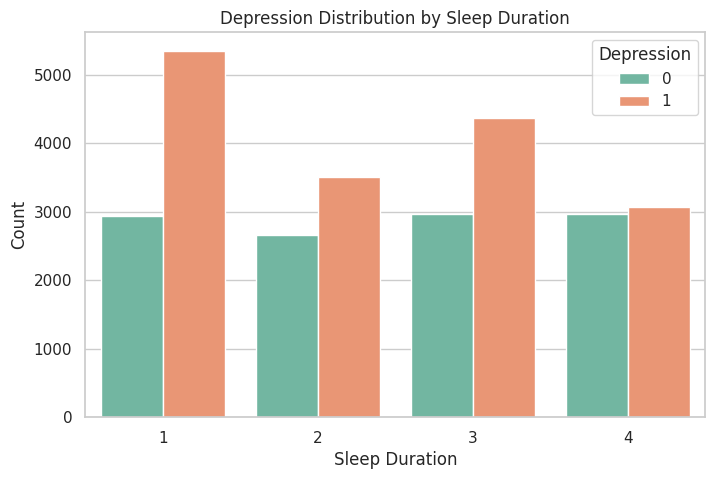

In [20]:
plt.figure(figsize=(8,5))
sns.countplot(x='Sleep Duration', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Sleep Duration")
plt.xlabel("Sleep Duration")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

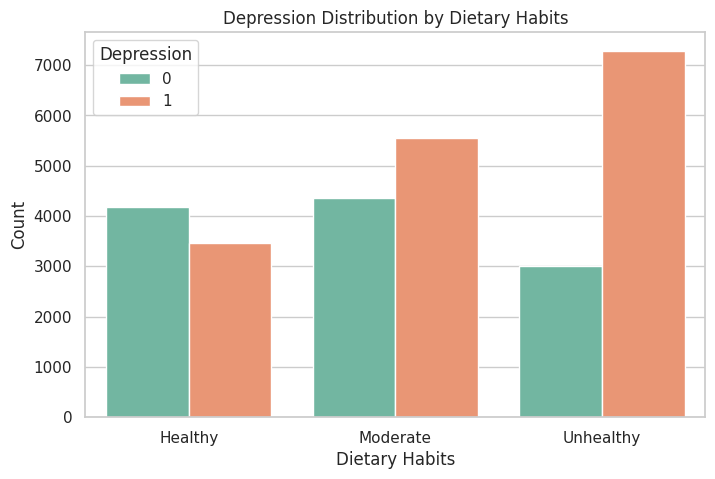

In [21]:
plt.figure(figsize=(8,5))
sns.countplot(x='Dietary Habits', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Dietary Habits")
plt.xlabel("Dietary Habits")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

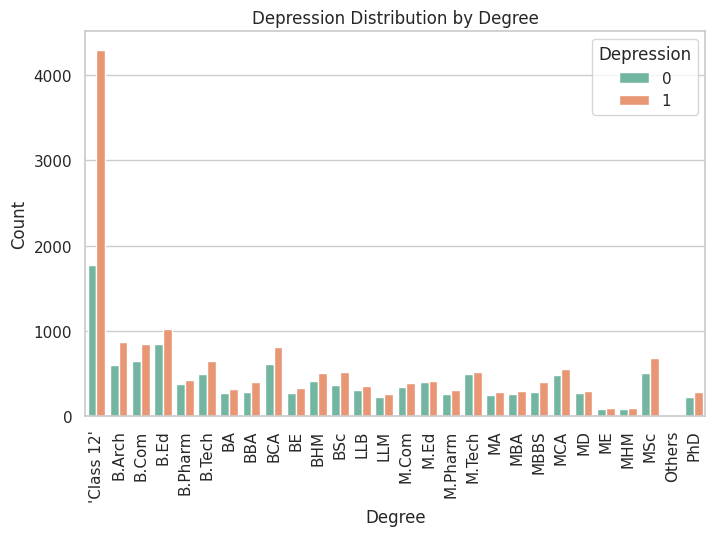

In [22]:
plt.figure(figsize=(8,5))
sns.countplot(x='Degree', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Degree")
plt.xlabel("Degree")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.legend(title="Depression")
plt.show()

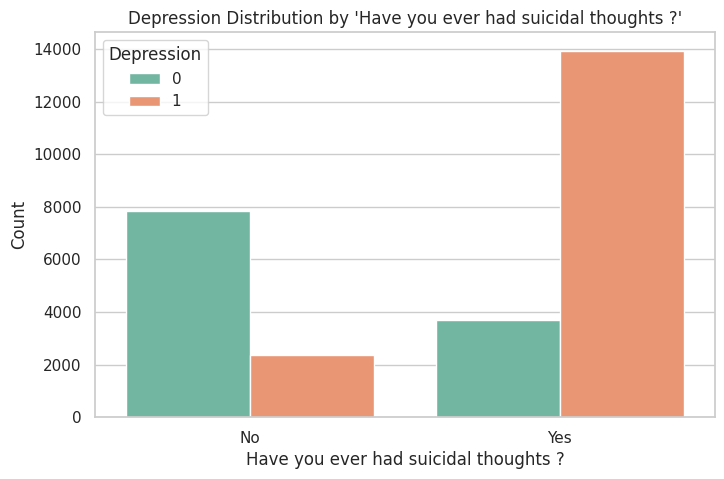

In [23]:
plt.figure(figsize=(8,5))
sns.countplot(x='Have you ever had suicidal thoughts ?', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by 'Have you ever had suicidal thoughts ?'")
plt.xlabel("Have you ever had suicidal thoughts ?")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

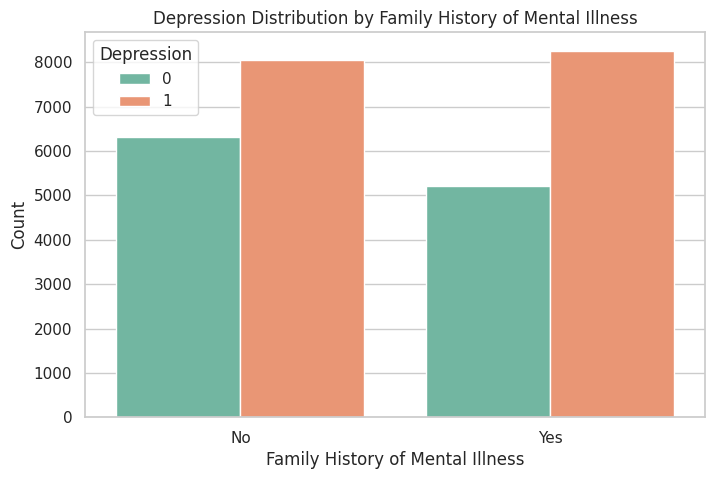

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(x='Family History of Mental Illness', hue='Depression', data=data, palette="Set2")
plt.title("Depression Distribution by Family History of Mental Illness")
plt.xlabel("Family History of Mental Illness")
plt.ylabel("Count")
plt.legend(title="Depression")
plt.show()

> ## 4.3 Distribution of Numerical Features

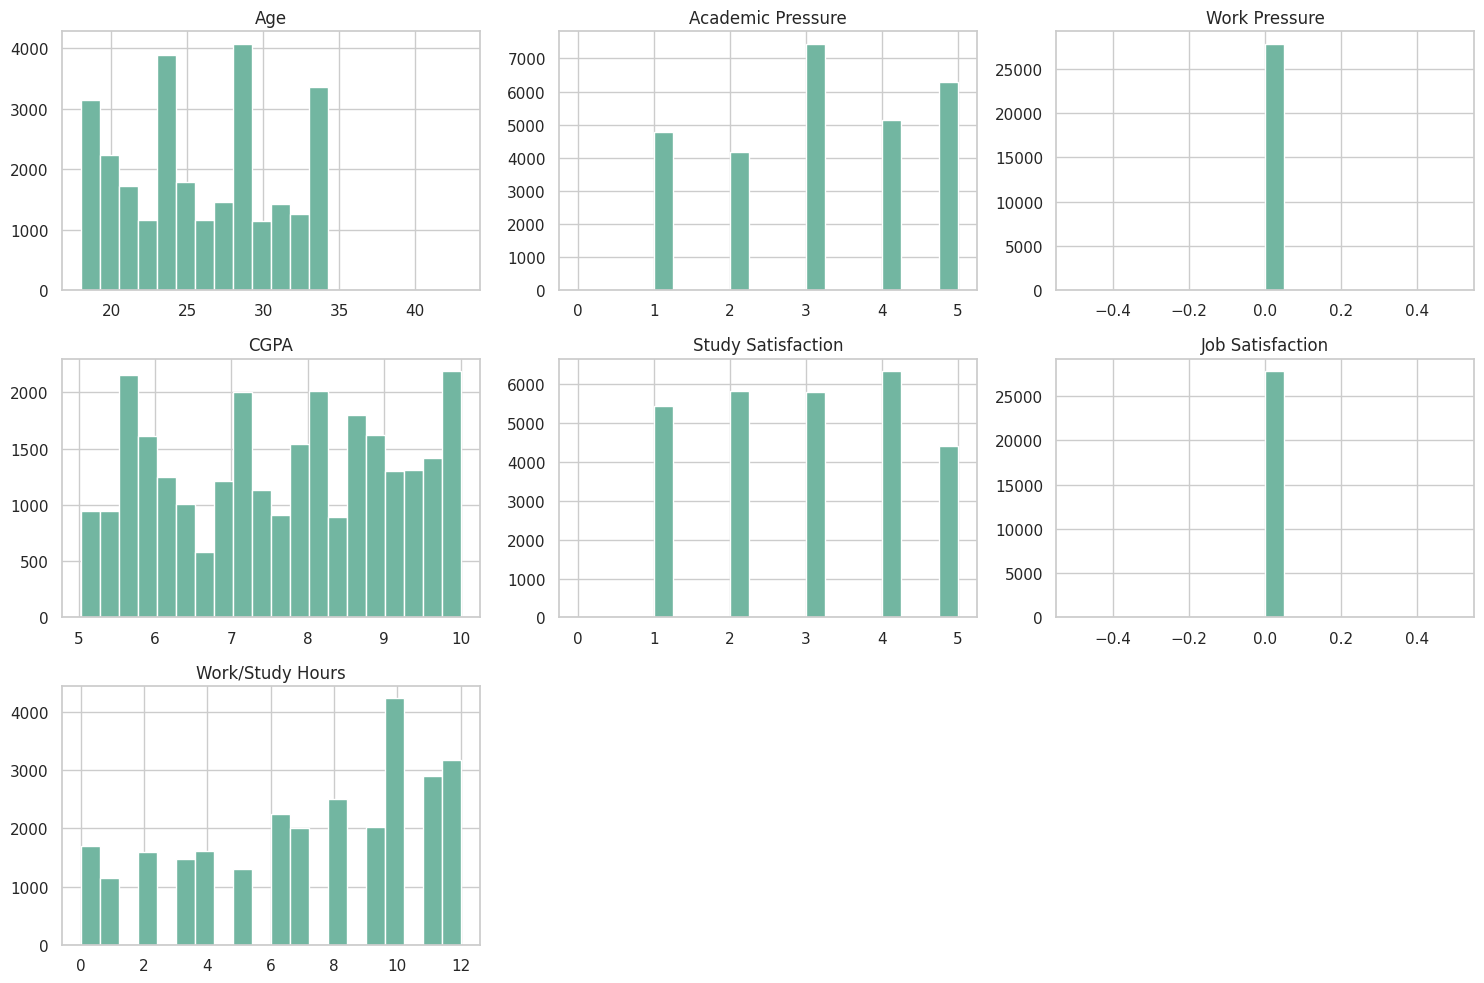

In [25]:
num_features = ['Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
                'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours']
data[num_features].hist(bins=20, figsize=(15,10), color=(114/255, 182/255, 161/255, 1))
plt.tight_layout()
plt.show()

> ## 4.4 Correlation Analysis

In [26]:
print("Checking values in Work Pressure:")
print(data['Work Pressure'].value_counts())

print("\nChecking values in Job Satisfaction:")
print(data['Job Satisfaction'].value_counts())

Checking values in Work Pressure:
Work Pressure
0.0    27845
Name: count, dtype: int64

Checking values in Job Satisfaction:
Job Satisfaction
0.0    27845
Name: count, dtype: int64


In [27]:
data = data.drop(columns=['Work Pressure', 'Job Satisfaction'])

data.shape

(27845, 16)

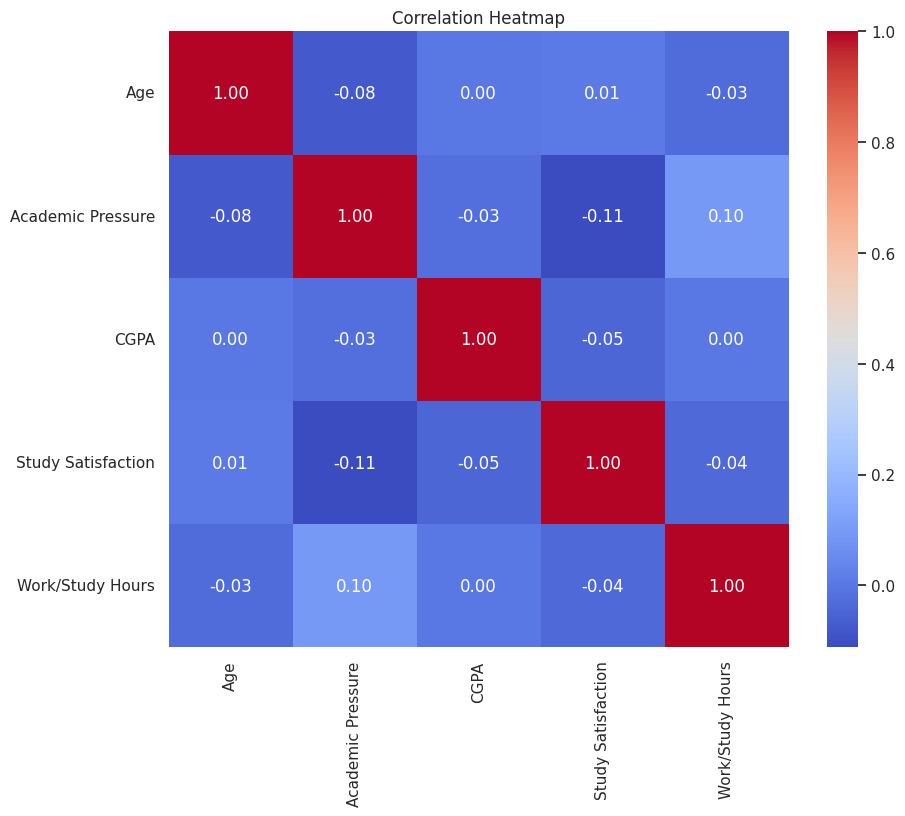

In [28]:
plt.figure(figsize=(10,8))
num_cols = ['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Work/Study Hours']
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

# Step 5: Feature Engineering

> ## Feature Selection

In [29]:
data = data.drop(columns=['Profession', 'City'])

data.shape

(27845, 14)

> ## Encoding Categorical Variables

In [30]:
cat_features = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Degree',
                'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness', 'Financial Stress']

data_encoded = pd.get_dummies(data, columns=cat_features, drop_first=True)

data_encoded

,id,Age,Academic Pressure,CGPA,Study Satisfaction,Work/Study Hours,Depression,Gender_Male,Sleep Duration_2,Sleep Duration_3,...,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Have you ever had suicidal thoughts ?_Yes,Family History of Mental Illness_Yes,Financial Stress_2.0,Financial Stress_3.0,Financial Stress_4.0,Financial Stress_5.0
0,2,33.0,5.0,8.97,2.0,3.0,1,True,True,False,...,False,False,False,False,True,False,False,False,False,False
1,8,24.0,2.0,5.90,5.0,3.0,0,False,True,False,...,False,False,False,False,False,True,True,False,False,False
2,26,31.0,3.0,7.03,5.0,9.0,0,True,False,False,...,False,False,False,False,False,True,False,False,False,False
3,30,28.0,3.0,5.59,2.0,4.0,1,False,False,True,...,False,False,False,False,True,True,False,False,False,True
4,32,25.0,4.0,8.13,3.0,1.0,0,False,True,False,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27873,140685,27.0,5.0,5.75,5.0,7.0,0,False,True,False,...,False,False,False,False,True,True,False,False,False,False
27874,140686,27.0,2.0,9.40,3.0,0.0,0,True,False,False,...,False,True,False,False,False,True,False,True,False,False
27875,140689,31.0,3.0,6.61,4.0,12.0,0,True,True,False,...,False,False,False,False,False,False,True,False,False,False
27876,140690,18.0,5.0,6.88,2.0,10.0,1,False,False,False,...,False,False,False,False,True,False,False,False,False,True


# Step 6: Machine Learning Model Building

In [31]:
drop_cols = ['id', 'Depression']
data_clean = data_encoded.drop(columns=drop_cols)

In [32]:
data_clean.shape

(27845, 44)

In [33]:
X = data_clean
y = data['Depression']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

> ## 6.1 Logistic Regression Model


> ### with sklearn

Logistic Regression Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2268
           1       0.87      0.88      0.87      3301

    accuracy                           0.85      5569
   macro avg       0.85      0.84      0.84      5569
weighted avg       0.85      0.85      0.85      5569



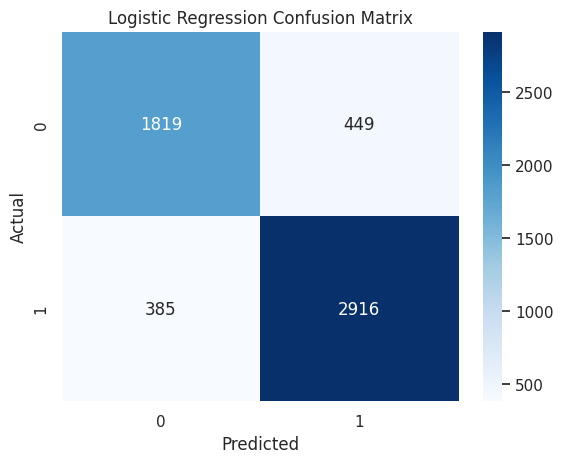

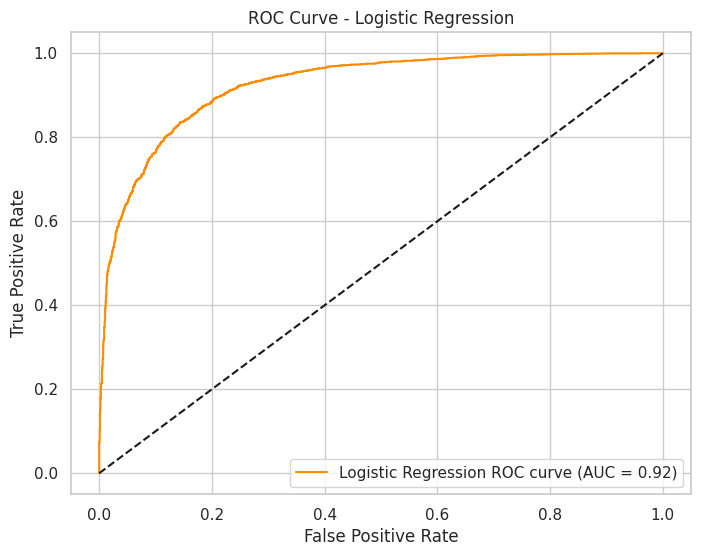

In [35]:
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

joblib.dump(log_model, 'logreg_sklearn.pkl')

y_pred_log = log_model.predict(X_test)
print("Logistic Regression Sklearn Classification Report:")
print(classification_report(y_test, y_pred_log))

cm_log = confusion_matrix(y_test, y_pred_log)
sns.heatmap(cm_log, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_log = log_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc_log:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

Logistic Regression Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      2268
           1       0.87      0.88      0.88      3301

    accuracy                           0.85      5569
   macro avg       0.85      0.84      0.85      5569
weighted avg       0.85      0.85      0.85      5569



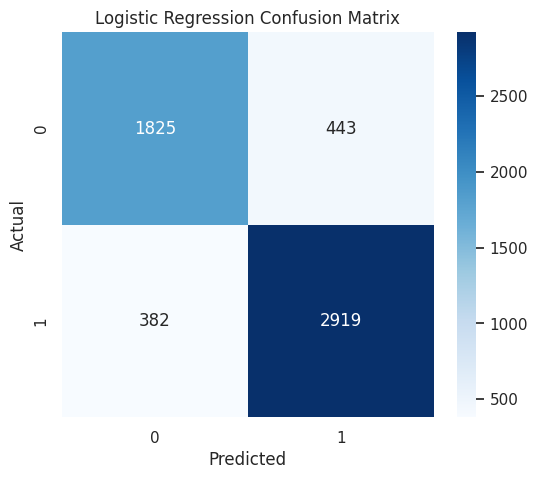

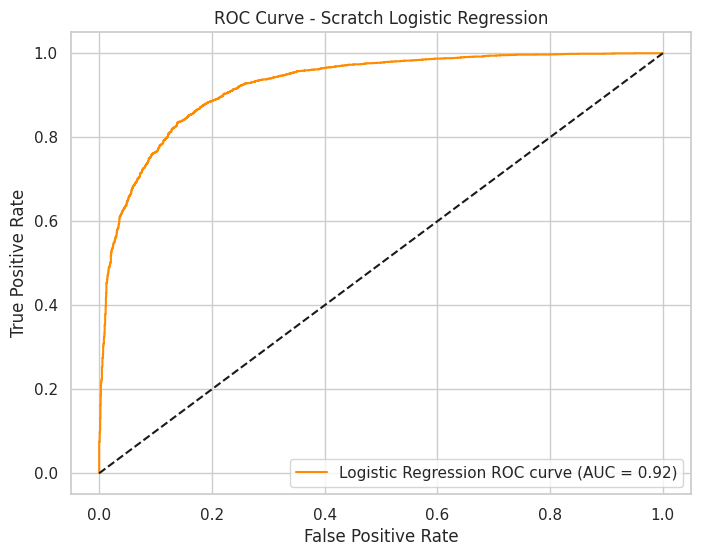

In [36]:
class LogisticRegressionScratch:
    def __init__(self, learning_rate=0.001, n_iters=1000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0

        for _ in range(self.n_iters):
            linear_model = np.dot(X, self.weights) + self.bias
            y_pred = self._sigmoid(linear_model)

            dw = (1 / n_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / n_samples) * np.sum(y_pred - y)

            self.weights -= self.lr * dw
            self.bias    -= self.lr * db

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self._sigmoid(linear_model)
        return np.where(y_pred > 0.5, 1, 0)

    def predict_proba(self, X):
        """
        Trả về mảng shape (n_samples, 2) như sklearn:
        [P(y=0), P(y=1)] cho mỗi sample.
        """
        linear_model = np.dot(X, self.weights) + self.bias
        probs = self._sigmoid(linear_model)
        return np.vstack([1 - probs, probs]).T

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

model = LogisticRegressionScratch(learning_rate=0.01, n_iters=5000)
model.fit(X_train, y_train)

joblib.dump(model, 'logreg_scratch.pkl')

y_pred = model.predict(X_test)
print("Logistic Regression Scratch Classification Report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC curve (AUC = {roc_auc_log:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Scratch Logistic Regression')
plt.legend(loc='lower right')
plt.show()


> ## 6.2 KNN Model

> ### with sklearn

KNN Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77      2268
           1       0.83      0.88      0.86      3301

    accuracy                           0.82      5569
   macro avg       0.82      0.81      0.82      5569
weighted avg       0.82      0.82      0.82      5569



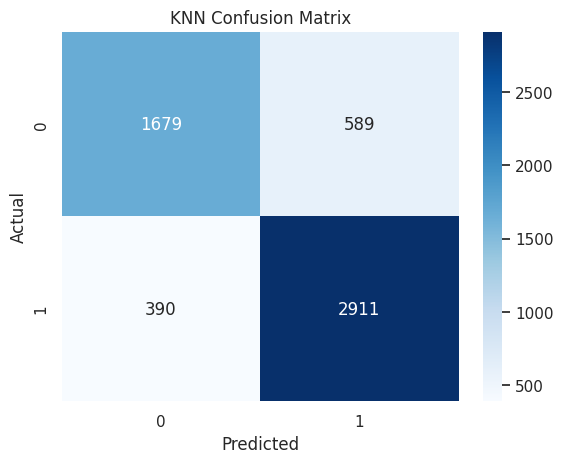

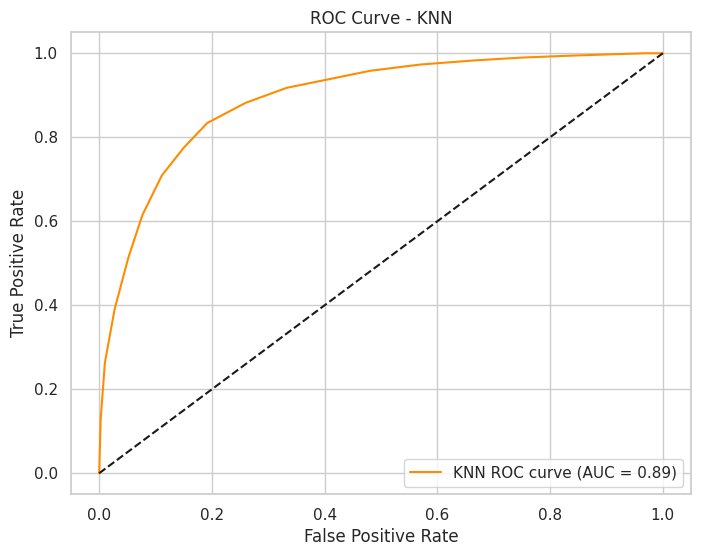

In [37]:
knn_model = KNeighborsClassifier(n_neighbors=18)
knn_model.fit(X_train, y_train)

joblib.dump(knn_model, 'knn_sklearn.pkl')

y_pred_knn = knn_model.predict(X_test)
print("KNN Sklearn Classification Report:")
print(classification_report(y_test, y_pred_knn))

cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_knn = knn_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'KNN ROC curve (AUC = {roc_auc_knn:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

KNN Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.71      0.77      2268
           1       0.82      0.90      0.86      3301

    accuracy                           0.82      5569
   macro avg       0.82      0.81      0.81      5569
weighted avg       0.82      0.82      0.82      5569



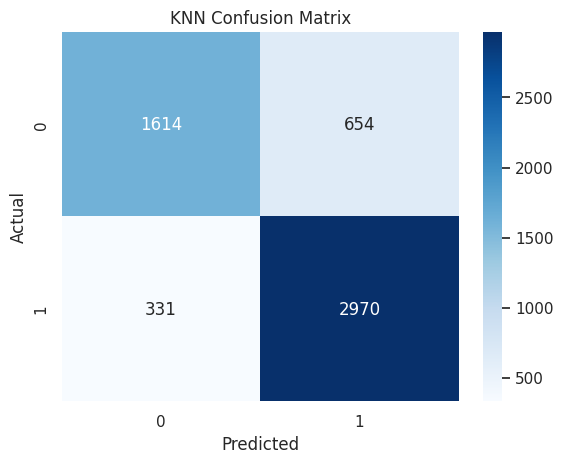

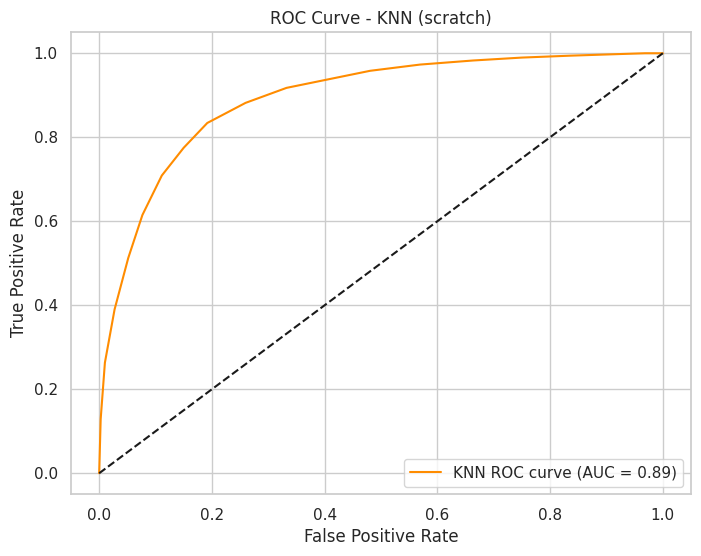

In [38]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.values if hasattr(X, 'values') else np.array(X)
        self.y_train = y.values if hasattr(y, 'values') else np.array(y)

    def _predict_one(self, x):
        distances = np.linalg.norm(self.X_train - x, axis=1)
        k_idx    = np.argsort(distances)[:self.k]
        labels   = self.y_train[k_idx]
        return Counter(labels).most_common(1)[0][0]

    def predict(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        return np.array([self._predict_one(x) for x in X_arr])

    def predict_proba(self, X):
        X_arr = X.values if hasattr(X, 'values') else np.array(X)
        probs = []
        for x in X_arr:
            distances = np.linalg.norm(self.X_train - x, axis=1)
            k_idx     = np.argsort(distances)[:self.k]
            labels    = self.y_train[k_idx]
            probs.append(np.mean(labels == 1))
        probs = np.array(probs)
        return np.vstack([1 - probs, probs]).T


clf = KNN(k=18)
clf.fit(X_train, y_train)

joblib.dump(clf, 'knn_scratch.pkl')

y_pred     = clf.predict(X_test)
y_prob_knn = clf.predict_proba(X_test)[:, 1]

print("KNN Scratch Classification Report:")
print(classification_report(y_test, y_pred))

cm_knn = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap='Blues')
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

fpr, tpr, _    = roc_curve(y_test, y_prob_knn)
roc_auc_knn    = auc(fpr, tpr)
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'KNN ROC curve (AUC = {roc_auc_knn:.2f})', color='darkorange')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - KNN (scratch)')
plt.legend(loc="lower right")
plt.show()

> ## 6.3 Random Forest Model

> ### with sklearn

Random Forest Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81      2268
           1       0.86      0.88      0.87      3301

    accuracy                           0.84      5569
   macro avg       0.84      0.84      0.84      5569
weighted avg       0.84      0.84      0.84      5569



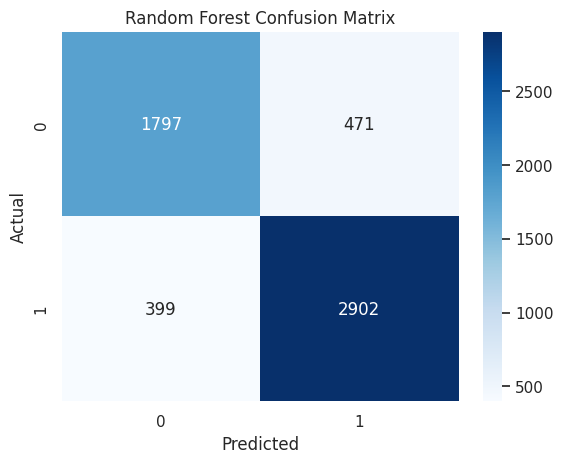

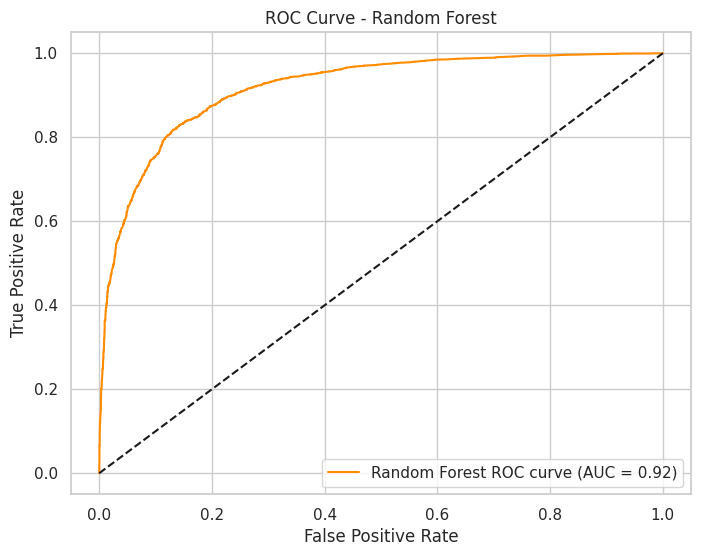

In [39]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=27, random_state=42)
rf_model.fit(X_train, y_train)

joblib.dump(rf_model, 'rf_sklearn.pkl')

y_pred_rf = rf_model.predict(X_test)

print("Random Forest Sklearn Classification Report:")
print(classification_report(y_test, y_pred_rf))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

100%|██████████| 100/100 [30:08<00:00, 18.09s/it]


Random Forest Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80      2268
           1       0.86      0.87      0.86      3301

    accuracy                           0.84      5569
   macro avg       0.83      0.83      0.83      5569
weighted avg       0.84      0.84      0.84      5569



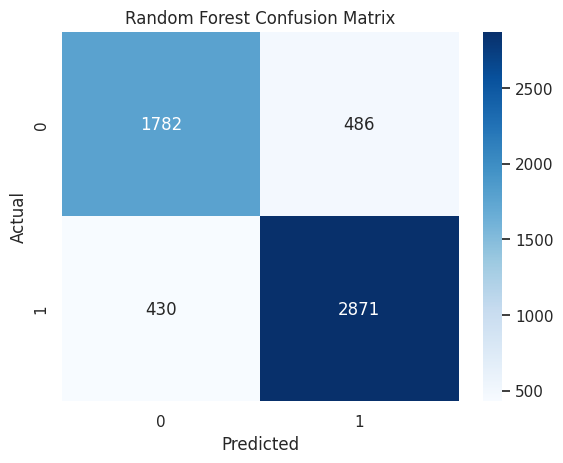

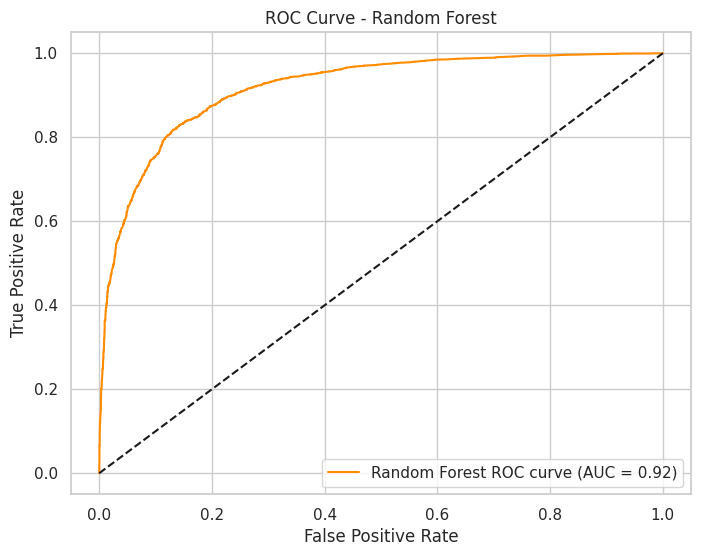

In [40]:
def entropy(y):
    hist = np.bincount(y)
    ps = hist / len(y)
    return -np.sum([p * np.log2(p) for p in ps if p > 0])


class Node:
    def __init__(
        self, feature=None, threshold=None, left=None, right=None, *, value=None
    ):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, min_samples_split=2, max_depth=100, n_feats=None):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.root = None

    def fit(self, X, y):
        self.n_feats = X.shape[1] if not self.n_feats else min(self.n_feats, X.shape[1])
        self.root = self._grow_tree(X, y)

    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _grow_tree(self, X, y, depth=0):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (
            depth >= self.max_depth
            or n_labels == 1
            or n_samples < self.min_samples_split
        ):
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)

        feat_idxs = np.random.choice(n_features, self.n_feats, replace=False)

        best_feat, best_thresh = self._best_criteria(X, y, feat_idxs)

        left_idxs, right_idxs = self._split(X[:, best_feat], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feat, best_thresh, left, right)

    def _best_criteria(self, X, y, feat_idxs):
        best_gain = -1
        split_idx, split_thresh = None, None
        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column)
            for threshold in thresholds:
                gain = self._information_gain(y, X_column, threshold)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = feat_idx
                    split_thresh = threshold

        return split_idx, split_thresh

    def _information_gain(self, y, X_column, split_thresh):
        parent_entropy = entropy(y)

        left_idxs, right_idxs = self._split(X_column, split_thresh)

        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l, e_r = entropy(y[left_idxs]), entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r

        ig = parent_entropy - child_entropy
        return ig

    def _split(self, X_column, split_thresh):
        left_idxs = np.argwhere(X_column <= split_thresh).flatten()
        right_idxs = np.argwhere(X_column > split_thresh).flatten()
        return left_idxs, right_idxs

    def _traverse_tree(self, x, node):
        if node.is_leaf_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def _most_common_label(self, y):
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

def bootstrap_sample(X, y):
    n_samples = X.shape[0]
    idxs = np.random.choice(n_samples, n_samples, replace=True)
    return X[idxs], y[idxs]


def most_common_label(y):
    counter = Counter(y)
    most_common = counter.most_common(1)[0][0]
    return most_common


class RandomForest:
    def __init__(self, n_trees=10, min_samples_split=2, max_depth=100, n_feats=None):
        self.n_trees = n_trees
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_feats = n_feats
        self.trees = []

    def fit(self, X, y):
        y = y.to_numpy()
        self.trees = []
        for _ in tqdm(range(self.n_trees)):
            tree = DecisionTree(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                n_feats=self.n_feats,
            )
            X_samp, y_samp = bootstrap_sample(X, y)
            tree.fit(X_samp, y_samp)
            self.trees.append(tree)

    def predict(self, X):
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        tree_preds = np.swapaxes(tree_preds, 0, 1)
        y_pred = [most_common_label(tree_pred) for tree_pred in tree_preds]
        return np.array(y_pred)

clf = RandomForest(n_trees=100, max_depth=27)
clf.fit(X_train, y_train)
y_pred_rf = clf.predict(X_test)

joblib.dump(clf, 'rf_scratch.pkl')

print("Random Forest Scratch Classification Report:")
print(classification_report(y_test, y_pred_rf))


cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_rf = rf_model.predict_proba(X_test)[:,1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest ROC curve (AUC = {roc_auc_rf:.2f})', color='darkorange')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right")
plt.show()

> ## 6.4 SVM Model

> ### with sklearn

SVM Sklearn Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.80      0.81      2268
           1       0.87      0.88      0.88      3301

    accuracy                           0.85      5569
   macro avg       0.85      0.84      0.84      5569
weighted avg       0.85      0.85      0.85      5569



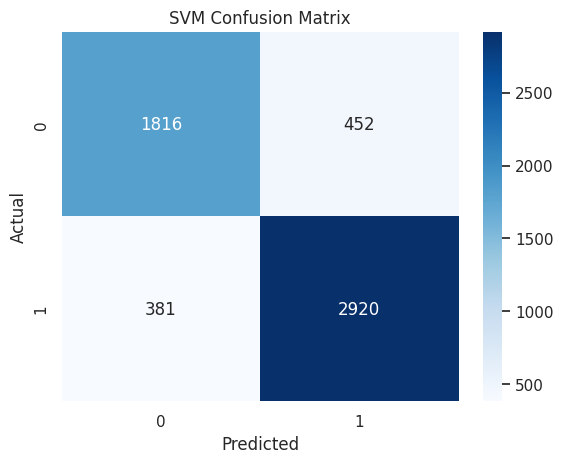

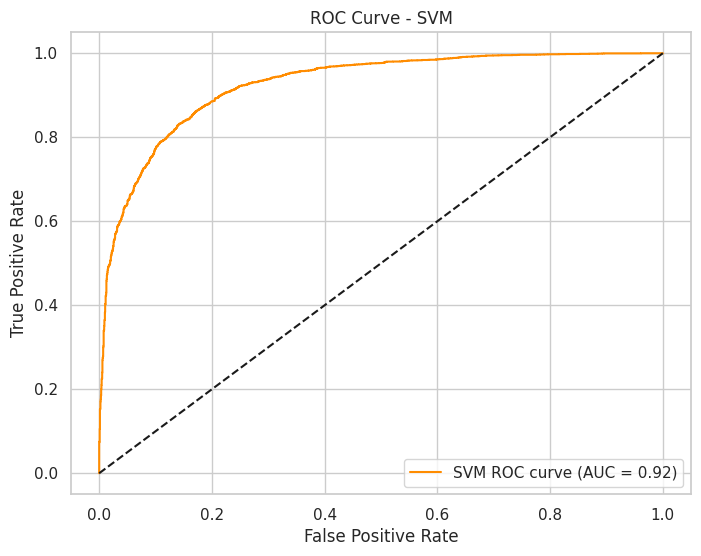

In [41]:
svm_model = SVC(kernel='linear', C=10, probability=True, random_state=42)
svm_model.fit(X_train, y_train)

joblib.dump(svm_model, 'svm_sklearn.pkl')

y_pred = svm_model.predict(X_test)
print("SVM Sklearn Classification Report:")
print(classification_report(y_test, y_pred))

cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

y_prob_svm = svm_model.predict_proba(X_test)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()

> ### with scratch implementation

SVM Scratch Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.82      0.81      2268
           1       0.88      0.87      0.87      3301

    accuracy                           0.85      5569
   macro avg       0.84      0.84      0.84      5569
weighted avg       0.85      0.85      0.85      5569



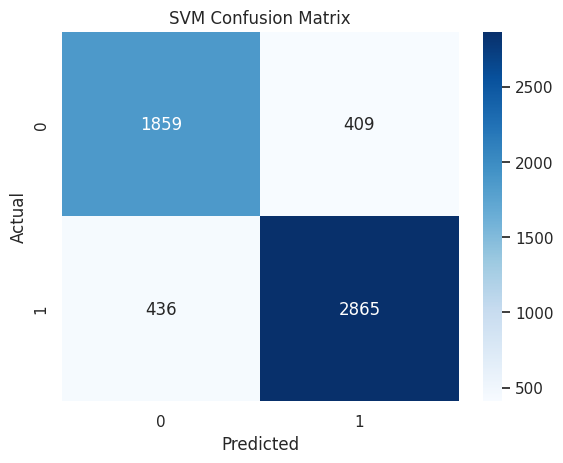

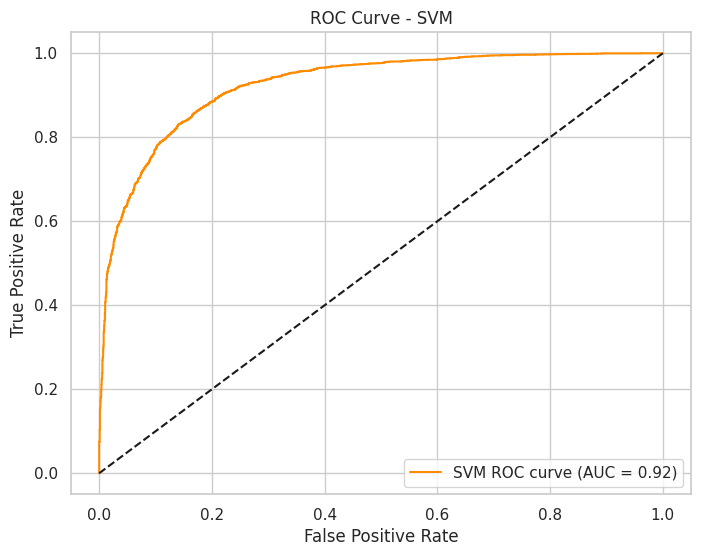

In [42]:
class SVMLinear:
    def __init__(self, C=1.0, threshold=1e-5):
        self.C = C
        self.threshold = threshold
        self.w = None
        self.b = None
        self.support_vectors = None
        self.support_labels = None
        self.support_lambdas = None

    def fit(self, X_train, y_train):
        # Convert labels to {-1, 1}
        y_train_svm = np.where(y_train == 0, -1, 1)
        N = X_train.shape[0]

        # Compute the kernel matrix K for linear kernel: K[i,j] = y_i * y_j * (x_i . x_j)
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                K[i, j] = y_train_svm[i] * y_train_svm[j] * np.dot(X_train[i], X_train[j])
        K = matrix(K)

        # Define QP problem parameters
        p = matrix(-np.ones((N, 1)))  # Linear term: -1 for all lambdas
        # Soft-margin constraints: 0 <= lambda <= C
        G = matrix(np.vstack((-np.eye(N), np.eye(N))))
        h = matrix(np.hstack((np.zeros(N), np.ones(N) * self.C)))
        A = matrix(y_train_svm, (1, N), 'd')  # Equality constraint: y^T lambda = 0
        b = matrix(0.0)

        # Solve QP problem
        solvers.options['show_progress'] = False
        sol = solvers.qp(K, p, G, h, A, b)
        l = np.array(sol['x']).flatten()  # Lagrange multipliers

        # Identify support vectors (lambda > small threshold)
        support_indices = np.where(l > self.threshold)[0]
        self.support_vectors = X_train[support_indices]
        self.support_labels = y_train_svm[support_indices]
        self.support_lambdas = l[support_indices]

        # Compute weight vector w
        self.w = np.sum(self.support_lambdas[:, None] * self.support_labels[:, None] * self.support_vectors, axis=0)

        # Compute bias b using average over support vectors
        self.b = np.mean(self.support_labels - self.support_vectors.dot(self.w))

    def predict(self, X):
        # Predict using decision function
        return np.sign(X.dot(self.w) + self.b)

    def save_model(self, filename):
        model_dict = {
            'w': self.w,
            'b': self.b,
            'support_vectors': self.support_vectors,
            'support_labels': self.support_labels,
            'support_lambdas': self.support_lambdas,
            'C': self.C,
            'threshold': self.threshold
        }
        joblib.dump(model_dict, filename)

    def load_model(self, filename):
        model_dict = joblib.load(filename)
        self.w = model_dict['w']
        self.b = model_dict['b']
        self.support_vectors = model_dict['support_vectors']
        self.support_labels = model_dict['support_labels']
        self.support_lambdas = model_dict['support_lambdas']
        self.C = model_dict['C']
        self.threshold = model_dict['threshold']

svm = SVMLinear(C=10, threshold=1e-5)
svm.fit(X_train, y_train)
svm.save_model('svm_scratch.pkl')

y_pred_svm = svm.predict(X_test)
y_pred = np.where(y_pred_svm == 1, 1, 0)  # Convert back to {0, 1} for metrics

# Classification report
print("SVM Scratch Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm_svm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap='Blues')
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Approximate probabilities for ROC curve using decision function
decision_values = X_test.dot(svm.w) + svm.b
y_prob_svm = 1 / (1 + np.exp(-decision_values))

# ROC curve
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.figure(figsize=(8, 6))
plt.plot(fpr_svm, tpr_svm, label=f'SVM ROC curve (AUC = {roc_auc_svm:.2f})', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()